In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Section 1: Data Science

TODO: Load the flights training data into 'data'.

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Practical topics in Machine Learning/EX1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Practical topics in Machine Learning/EX1


In [ ]:
data = pd.read_csv('./flight_delays_train.csv')

In [ ]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


How many flights got delayed at Charlotte?

In [ ]:
CLT_flights = data[data['Origin'] == "CLT"]
print("{} flights got delayed at Charlotte.".format(CLT_flights[CLT_flights['dep_delayed_15min'] == "Y"].shape[0]))

288 flights got delayed at Charlotte.


Show the number of departures per hour-of-day.

In [ ]:
# You are adviced to use 'groupby'. More info can be found here:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

data['DepHour'] = data["DepTime"] // 100

for i, depHour in enumerate(data['DepHour'].values):
  if depHour >= 24:
    data.loc[i, 'DepHour'] = depHour - 24

# Found it easier to use iloc here.
NumOfDepPerHour = data.iloc[:, 9].value_counts().sort_index()
# print(NumOfDepPerHour)
for hour, num_dep in zip(NumOfDepPerHour.index, NumOfDepPerHour):
  print("Hour: {}  {}Departures: {}".format(hour, " " if hour < 10 else "", num_dep))

Hour: 0   Departures: 331
Hour: 1   Departures: 82
Hour: 2   Departures: 27
Hour: 3   Departures: 8
Hour: 4   Departures: 38
Hour: 5   Departures: 1636
Hour: 6   Departures: 6315
Hour: 7   Departures: 6329
Hour: 8   Departures: 6620
Hour: 9   Departures: 6409
Hour: 10  Departures: 6363
Hour: 11  Departures: 6340
Hour: 12  Departures: 6363
Hour: 13  Departures: 6178
Hour: 14  Departures: 6006
Hour: 15  Departures: 6170
Hour: 16  Departures: 6112
Hour: 17  Departures: 6562
Hour: 18  Departures: 6110
Hour: 19  Departures: 5500
Hour: 20  Departures: 4430
Hour: 21  Departures: 3505
Hour: 22  Departures: 1787
Hour: 23  Departures: 779


Plot number of departures (Y axis) per hour-of-day (X axis).

In [ ]:
def plot(title, x, x_name, y, y_name):
  figure = plt.figure(figsize=(8, 6), dpi=80, facecolor='w')

  plt.title(title)
  plt.xlabel(x_name)
  plt.ylabel(y_name)

  plt.xticks(list(x))

  for hour, num_d in zip(x, y):
    plt.scatter(hour, num_d)

  plt.show()

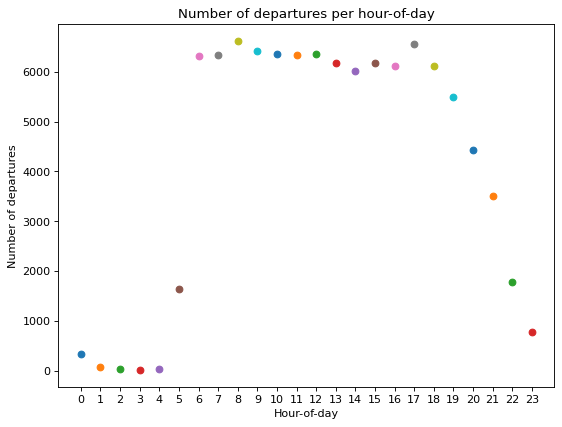

In [ ]:
plot("Number of departures per hour-of-day", NumOfDepPerHour.index, "Hour-of-day", NumOfDepPerHour.values,"Number of departures")

Plot the average number of delays per hour-of-day.

Hour: 0   Delays: 56.193%
Hour: 1   Delays: 63.415%
Hour: 2   Delays: 44.444%
Hour: 3   Delays: 62.500%
Hour: 4   Delays: 7.895%
Hour: 5   Delays: 0.672%
Hour: 6   Delays: 2.518%
Hour: 7   Delays: 5.704%
Hour: 8   Delays: 7.689%
Hour: 9   Delays: 11.297%
Hour: 10  Delays: 13.296%
Hour: 11  Delays: 14.953%
Hour: 12  Delays: 17.177%
Hour: 13  Delays: 19.440%
Hour: 14  Delays: 19.697%
Hour: 15  Delays: 22.415%
Hour: 16  Delays: 23.380%
Hour: 17  Delays: 23.819%
Hour: 18  Delays: 27.971%
Hour: 19  Delays: 30.509%
Hour: 20  Delays: 33.657%
Hour: 21  Delays: 39.030%
Hour: 22  Delays: 43.089%
Hour: 23  Delays: 46.213%



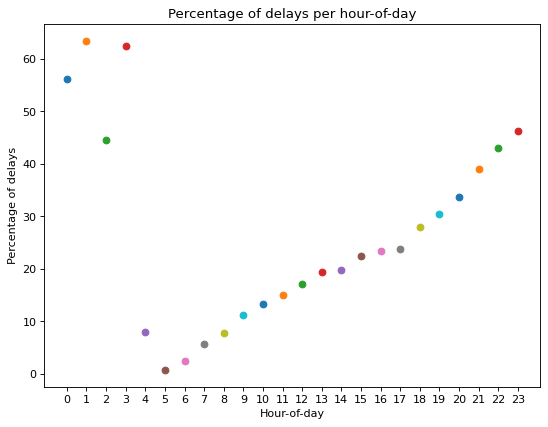

In [ ]:
x = data.loc[:, ['DepHour', 'dep_delayed_15min']]
delayed = x[x['dep_delayed_15min'] == "Y"]

delays_per_hour = delayed.iloc[:, 0].value_counts().sort_index().divide(NumOfDepPerHour) * 100

for hour, delays in zip(delays_per_hour.index, delays_per_hour):
  print("Hour: {}  {}Delays: {}%{}".format(hour, " " if hour < 10 else "", '%.3f' % delays, "\n" if hour == 23 else ""))

plot("Percentage of delays per hour-of-day", delays_per_hour.index, "Hour-of-day", delays_per_hour,"Percentage of delays")

Find the worse pair of origin and carrier.

In [ ]:
# You may want to use 'idxmax' (like argmax, returning the row with max value of specific column)

origin_carrier = data.loc[:, ['UniqueCarrier', 'Origin', 'dep_delayed_15min']]
Delayed = origin_carrier[origin_carrier['dep_delayed_15min'] == "Y"]
worst_pair = Delayed.groupby(['Origin', 'UniqueCarrier']).count().idxmax()[0]

print("Worst pair of origin and carrier:", worst_pair)

Worst pair of origin and carrier: ('ATL', 'DL')


# Section 2: Supervised Learning
Here, you are requested to use all features to predict the response parameter dep_delayed_15min.

* Note: some of those things are covered in notebooks 1-4.

In [ ]:
# TODO: encode all categorical features as one-hot representation

X = pd.read_csv('./flight_delays_train.csv')
categorial_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

for feature in categorial_features:
  X = pd.concat([X, pd.get_dummies(X[feature], prefix=feature)], axis=1)

X = X.drop(columns=categorial_features)

In [ ]:
X.head()

,DepTime,Distance,dep_delayed_15min,Month_c-1,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,Month_c-6,Month_c-7,Month_c-8,Month_c-9,DayofMonth_c-1,DayofMonth_c-10,DayofMonth_c-11,DayofMonth_c-12,DayofMonth_c-13,DayofMonth_c-14,DayofMonth_c-15,DayofMonth_c-16,DayofMonth_c-17,DayofMonth_c-18,DayofMonth_c-19,DayofMonth_c-2,DayofMonth_c-20,DayofMonth_c-21,DayofMonth_c-22,DayofMonth_c-23,DayofMonth_c-24,DayofMonth_c-25,DayofMonth_c-26,DayofMonth_c-27,DayofMonth_c-28,DayofMonth_c-29,DayofMonth_c-3,DayofMonth_c-30,DayofMonth_c-31,...,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SOP,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_STX,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TEX,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TTN,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,1934,732,N,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1548,834,N,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1422,416,N,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1015,872,N,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1828,423,Y,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Splitting the data

In [ ]:
y = X['dep_delayed_15min']
X = X.drop(columns=['dep_delayed_15min'])

In [ ]:
# TODO: Split the data to train and test. Use test_size=0.3, and random_state=1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Fitting Logistic Regression classifier to the training set

In [ ]:
# TODO: Fit a LogisticRegression classifier to the training set
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Printing the Logistic Regression's Confusion matrix

In [ ]:
# TODO: print confusion matrix over the testing set
y_hat_test = lr.predict(X_test)
conf_mx = confusion_matrix(y_test, y_hat_test, labels=['Y', 'N'])
print(conf_mx)

[[  325  5261]
 [  265 24149]]


Calculating Precision, Recall and F score for all 4 classifiers

In [ ]:
# TODO: Similarly, print precision/recall for the following classifiers:
# sklearn.naive_bayes.BernoulliNB
# sklearn.neighbors.KNeighborsClassifier
# sklearn.svm.LinearSVC

def apply_classifier(clf, clf_name, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_hat_test = clf.predict(X_test)
  conf_mx = confusion_matrix(y_test, y_hat_test, labels=['Y', 'N'])

  TruePositives = conf_mx[0][0]
  FalseNegatives = conf_mx[0][1]
  FalsePositives = conf_mx[1][0]
  TrueNegatives = conf_mx[1][1]

  precision = TruePositives / (TruePositives + FalsePositives)
  recall = TruePositives / (TruePositives + FalseNegatives)
  f_score = (2 * precision * recall) / (precision + recall)

  print("{}\nPrecision: {}\nRecall: {}\nF score: {}\n".format(clf_name, '%.3f' % precision, '%.3f' % recall,'%.3f' % f_score))

In [ ]:
apply_classifier(LogisticRegression(), "Logistic Regression Classifier", X_train, y_train, X_test, y_test)
apply_classifier(BernoulliNB(), "Naive Bayes (Bernoulli) Classifier", X_train, y_train, X_test, y_test)
apply_classifier(KNeighborsClassifier(), "KNN Classifier", X_train, y_train, X_test, y_test)
apply_classifier(LinearSVC(random_state=0, max_iter=2500), "SVM (Linear SVC) Classifier", X_train, y_train, X_test, y_test)

Logistic Regression Classifier
Precision: 0.551
Recall: 0.058
F score: 0.105

Naive Bayes (Bernoulli) Classifier
Precision: 0.318
Recall: 0.015
F score: 0.029

KNN Classifier
Precision: 0.397
Recall: 0.184
F score: 0.252



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM (Linear SVC) Classifier
Precision: 0.146
Recall: 0.020
F score: 0.036



**Attempt to improve the classifiers results by treating the 'Distance' and
'DepTime' features as categorial features**

In [ ]:
X['Distance'].describe()

count    100000.00000
mean        729.39716
std         574.61686
min          30.00000
25%         317.00000
50%         575.00000
75%         957.00000
max        4962.00000
Name: Distance, dtype: float64

In [ ]:
# Using bins on the 'Distance' feature in order to treat it as categorial feature.

bins = [0, 2000, 4000, 5000]
labels = range(1, 4)
X['Distance_binned'] = pd.cut(X['Distance'], bins=bins, labels=labels)

X = X.drop(columns=['Distance'])

In [ ]:
X['DepTime'].describe()

count    100000.000000
mean       1341.523880
std         476.378445
min           1.000000
25%         931.000000
50%        1330.000000
75%        1733.000000
max        2534.000000
Name: DepTime, dtype: float64

In [ ]:
# Using bins on the 'DepTime' feature in order to treat it as categorial feature.

bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2600]
labels = range(1, 9)
X['DepTime_binned'] = pd.cut(X['DepTime'], bins=bins, labels=labels)

X = X.drop(columns=['DepTime'])

In [ ]:
# Splitting the data with the new featurs to train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
apply_classifier(LogisticRegression(max_iter=500), "Logistic Regression Classifier", X_train, y_train, X_test, y_test)
apply_classifier(BernoulliNB(), "Naive Bayes (Bernoulli) Classifier", X_train, y_train, X_test, y_test)
apply_classifier(KNeighborsClassifier(), "KNN Classifier", X_train, y_train, X_test, y_test)
apply_classifier(LinearSVC(random_state=0, max_iter=2500), "SVM (Linear SVC) Classifier", X_train, y_train, X_test, y_test)

Logistic Regression Classifier
Precision: 0.554
Recall: 0.071
F score: 0.125

Naive Bayes (Bernoulli) Classifier
Precision: 0.318
Recall: 0.015
F score: 0.029

KNN Classifier
Precision: 0.436
Recall: 0.201
F score: 0.275

SVM (Linear SVC) Classifier
Precision: 0.560
Recall: 0.017
F score: 0.033

